In [1]:
import pandas as pd
# train/test split
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Data Inspection


In [3]:
len(train_df)+len(test_df)

27480

In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,28ac06f416,good luck with your auction,good luck with your auction,positive
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative
4,7b36e9e7a5,not so good mood..,not so good mood..,negative


In [5]:
test_df.head()

,textID,text,selected_text
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.


# Data training

## Data Preprocessing

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re #regex

#to tokenize
from nltk.tokenize import word_tokenize
#to remove stop words
from nltk.corpus import stopwords
#for stemming
from nltk.stem.porter import PorterStemmer #voir pour stem en français ou lemmatization -> utilisation dictionnaire

def dataPreprocessing(text):
    #to remove punctation
    text = re.sub(r'[.,"\'-?:!;]', '', text)

    #transfrom in an array of words
    words = word_tokenize(text)

    #we remove stop_words from words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    #we stem the words
    porter = PorterStemmer()
    stems = []
    for w in words:
        stems.append(porter.stem(w))

    return stems

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dorian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dorian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
Comments = []
Marks=[]

target_conversion = {
    'neutral': 0,
    'positive': 1,
    'negative': -1
}

for index, row in train_df.iterrows():
    # Accédez aux valeurs de chaque colonne dans la ligne courante
    #Comments.append(dataPreprocessing(row['selected_text']))
    Comments.append(dataPreprocessing(extract_selected_text(row['text'])))
    Marks.append(target_conversion[row['sentiment']])

## Vectorization

In [16]:
import math
from tqdm import tqdm
!pip install --upgrade tqdm

def wordsOccurence(commentPrepocessed, ListOfWords, CounterForWordsInDocuments):
    FrequencyOfWords = [0] * len(ListOfWords)
    length = len(commentPrepocessed)

    for w in commentPrepocessed:
        if w not in ListOfWords:
            ListOfWords.append(w)
            FrequencyOfWords.append(1 / length)
            CounterForWordsInDocuments.append(1)
        else:
            index = ListOfWords.index(w)
            if FrequencyOfWords[index] == 0:
                CounterForWordsInDocuments[index] += 1
            FrequencyOfWords[index] += 1 / length
    return ListOfWords, FrequencyOfWords, CounterForWordsInDocuments

def inverseDocumentFrequency(CounterForWordsInDocuments, numberOfComments):
    CommentsIDF = []
    for i in (range(len(CounterForWordsInDocuments))):
        CommentsIDF.append(math.log10(numberOfComments / CounterForWordsInDocuments[i]))
    return CommentsIDF

def TD_IDF(CommentsTermFrequency, CommentsIDF):
    Results = []
    for i in tqdm(range(len(CommentsTermFrequency)), desc="Calculating TF-IDF"):
        tempResult = []
        for j in (range(len(CommentsTermFrequency[i]))):
            tempResult.append(CommentsTermFrequency[i][j] * CommentsIDF[j])
        Results.append(tempResult)
    return Results


In [17]:
import pandas as pd


def vectorize(Comments):
    CommentsTermFrequency=[]
    ListOfWords=[]
    CounterForWordsInDocuments=[]#if a word appears at least once in a comment, we add 1
    for commentPrepocessed in Comments:
        ListOfWords, FrequencyOfWords, CounterForWordsInDocuments = wordsOccurence(commentPrepocessed, ListOfWords, CounterForWordsInDocuments)
        CommentsTermFrequency.append(FrequencyOfWords)

    numberOfComments=len(Comments)

    CommentsIDF=inverseDocumentFrequency(CounterForWordsInDocuments, numberOfComments)

    ResultsTF_IDF = TD_IDF(CommentsTermFrequency, CommentsIDF)

    df = pd.DataFrame(ResultsTF_IDF, columns=ListOfWords)
    df = df.fillna(0)

    return df

In [18]:
df1 = pd.DataFrame(Marks, columns=['sentiment'])
df2 = vectorize(Comments)

Calculating TF-IDF: 100%|███████████████████████████████████████████████████████| 24732/24732 [00:38<00:00, 648.58it/s]


In [19]:
df = pd.concat([df1, df2], axis = 1)

print(df.describe(include='all'))
print(df)

          sentiment          good          luck       auction          judg  \
count  24732.000000  24732.000000  24732.000000  24732.000000  24732.000000   
mean       0.028627      0.013953      0.002060      0.000059      0.000410   
std        0.770806      0.072706      0.035123      0.009312      0.027820   
min       -1.000000      0.000000      0.000000      0.000000      0.000000   
25%       -1.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.279650      2.332561      1.464420      3.393259   

               book          look         cover         enjoy         watch  \
count  24732.000000  24732.000000  24732.000000  24732.000000  24732.000000   
mean       0.002424      0.007946      0.000790      0.003202      0.008926   
std        0.037460      0.057342      0.021584    

## Data Prediction

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df2
y = df1['sentiment']

model = LogisticRegression(max_iter=5000)  # Initialize the model with 5000 iterations

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into train and validation sets

model.fit(X_train, y_train)  # Train the model on the training data

predictions = model.predict(X_val)  # Make predictions on the validation data

# Calculate the F1 score
f1 = f1_score(y_val, predictions, average='weighted')

# Print the F1 score
print("F1 score:", f1)


F1 score: 0.6496621294318358


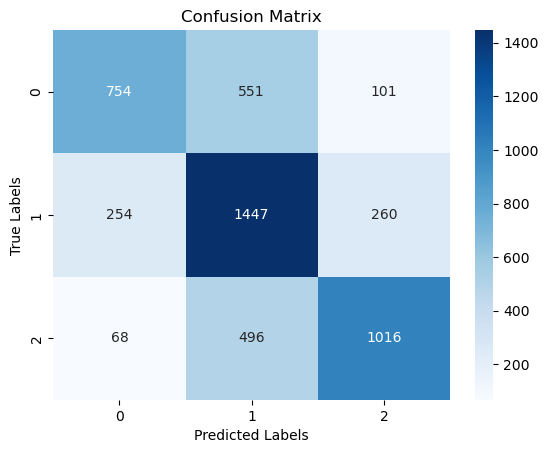

In [21]:
# Create a confusion matrix
cm = confusion_matrix(y_val, predictions)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

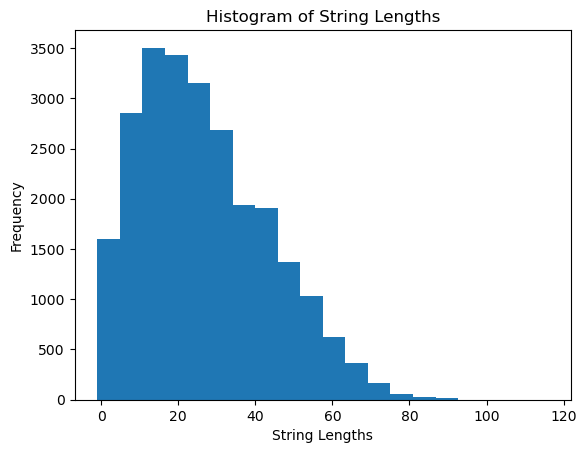

In [29]:
lengths = [sum(len(word) for word in sublist) + len(sublist) - 1 for sublist in Comments]

# Build the histogram
plt.hist(lengths, bins=20)  # You can adjust the number of bins as needed

# Add labels and a title
plt.xlabel('String Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of String Lengths')

# Display the histogram
plt.show()


In [47]:
import pandas as pd

df1B = pd.DataFrame(Marks, columns=['sentiment'])
Comments2 = [sublist for sublist in Comments if len(sublist) > 2]
df2B = vectorize(Comments2)

# Obtenir les indices des lignes à conserver
indices_to_keep = [index for index, sublist in enumerate(Comments) if len(sublist) > 2]

# Filtrer les lignes correspondantes dans df1B
df1B = df1B.iloc[indices_to_keep]

# Maintenant, vous avez df1B et df2B avec les mêmes lignes supprimées


Calculating TF-IDF: 100%|███████████████████████████████████████████████████████| 19285/19285 [00:30<00:00, 623.59it/s]


In [58]:
df3B = pd.DataFrame(train_df, columns=['selected_text'])
df3B = df3B
import pandas as pd

# Concaténer les mots avec des espaces dans chaque sous-liste
concatenated_comments = [' '.join(sublist) for sublist in Comments]

# Créer le DataFrame df4B
df4B = pd.DataFrame(concatenated_comments, columns=['text'])

# Afficher le DataFrame df4B
print(df4B)

             
             
import numpy as np

def jaccard_score(df1, df2):
    set1 = set(df1.values.flatten())
    set2 = set(df2.values.flatten())
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    jaccard = intersection / union
    return jaccard

# Exemple d'utilisation
score = jaccard_score(df4B, df3B)
print("Jaccard Score:", score)
print(df4B.shape)
print(df3B.shape)

                                                    text
0                                      good luck auction
1                                   judg book look cover
2                                     enjoy watch mental
3                                      call belgium suck
4                                              good mood
...                                                  ...
24727  get closer log left hand swollen ` wear wed ri...
24728                                     i ` draw email
24729                                          see thank
24730                             internet th grade dive
24731                  content content stori life remind

[24732 rows x 1 columns]
Jaccard Score: 0.0037102720866196855
(24732, 1)
(24732, 1)


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df2B
y = df1B['sentiment']

model = LogisticRegression(max_iter=5000)  # Initialize the model with 5000 iterations

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Split the data into train and validation sets

model.fit(X_train, y_train)  # Train the model on the training data

predictions = model.predict(X_val)  # Make predictions on the validation data

# Calculate the F1 score
f1 = f1_score(y_val, predictions, average='weighted')

# Print the F1 score
print("F1 score:", f1)


F1 score: 0.6419513841144551


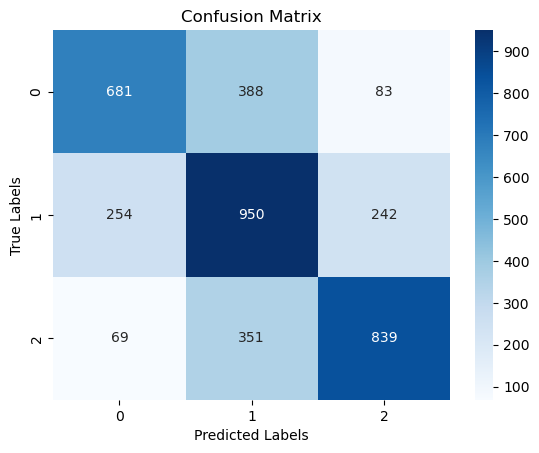

In [49]:
# Create a confusion matrix
cm = confusion_matrix(y_val, predictions)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X = df2
y = df1['sentiment']

model = SVC()  # Initialize the SVM model

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into train and validation sets

model.fit(X_train, y_train)  # Train the model on the training data

predictions = model.predict(X_val)  # Make predictions on the validation data

# Calculate the F1 score
f1 = f1_score(y_val, predictions, average='weighted')

# Print the F1 score
print("F1 score SVM:", f1)


F1 score SVM: 0.8162367117292044


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression

X = df2
y = df1['sentiment']

model = LogisticRegression(max_iter=5000)  # Initialize the model with 5000 iterations

val_Comments = []

for index, row in test_df.iterrows():
    val_Comments.append(dataPreprocessing(row['selected_text']))

val_df2 = vectorize(val_Comments)

common_columns = X.columns.intersection(val_df2.columns)  # Get the common column names

val_X = val_df2[common_columns]  # Select only the common columns in the validation data

model.fit(X[common_columns], y)  # Train the model on the data

predictions = model.predict(val_X)  # Make predictions on the validation data

import pandas as pd

# Replace the numeric predictions with corresponding sentiment labels
#predictions_labels = ['negative' if p == -1 else 'neutral' if p == 0 else 'positive' for p in predictions]

# Create a DataFrame with predictions and the same index as test_df
predictions_df = pd.DataFrame(predictions, columns=['sentiment'], index=test_df['textID'])


# Export the predictions to a CSV file
predictions_df.to_csv('predictions.csv')

Calculating TF-IDF: 100%|████████████████████████████████████████████████████████| 2748/2748 [00:00<00:00, 2897.47it/s]


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

X = df2
y = df1['sentiment']

model = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize the Random Forest classifier with 100 trees

val_Comments = []

for index, row in test_df.iterrows():
    val_Comments.append(dataPreprocessing(row['selected_text']))

val_df2 = vectorize(val_Comments)

common_columns = X.columns.intersection(val_df2.columns)  # Get the common column names

val_X = val_df2[common_columns]  # Select only the common columns in the validation data

model.fit(X[common_columns], y)  # Train the model on the data

predictions = model.predict(val_X)  # Make predictions on the validation data

import pandas as pd

# Replace the numeric predictions with corresponding sentiment labels
#predictions_labels = ['negative' if p == -1 else 'neutral' if p == 0 else 'positive' for p in predictions]

# Create a DataFrame with predictions and the same index as test_df
predictions_df = pd.DataFrame(predictions, columns=['sentiment'], index=test_df['textID'])

# Export the predictions to a CSV file
predictions_df.to_csv('predictions.csv')


Calculating TF-IDF: 100%|████████████████████████████████████████████████████████| 2748/2748 [00:00<00:00, 2965.42it/s]


In [14]:
#!pip install spacy
import spacy
from autocorrect import Speller

def extract_selected_text(text):
    # Charger le modèle linguistique anglais de SpaCy
    nlp = spacy.load("en_core_web_sm")
    
    # Créer une instance du correcteur orthographique
    spell = Speller(lang='en')

    # Correction orthographique du texte
    text = spell(text)
    
    # Analyser le texte
    doc = nlp(text)
    
    # Extraire les parties de la phrase qui sont des noms, des verbes ou des adjectifs
    selected_tokens = [token.text for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ']]
    
    # Rejoindre les tokens sélectionnés pour former la sous-phrase
    selected_text = ' '.join(selected_tokens)
    
    return selected_text

# Exemple d'utilisation
text = "Omg I just woke up after only sleeping for 3hrs, and my arm is just aching... It hurts so bad"
selected_text = extract_selected_text(text)
print("Texte extrait :", selected_text)


Texte extrait : woke sleeping arm acting hurts bad


In [19]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch

# Charger les données d'entraînement et de test à partir des fichiers CSV
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#train_df['selected_text'] = train_df['text'].apply(extract_selected_text)
#test_df['selected_text'] = test_df['text'].apply(extract_selected_text)

# Séparer les caractéristiques (X) et les étiquettes (y) pour l'entraînement
X = train_df['selected_text']
y = train_df['sentiment']

# Séparer les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instancier le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encodage des textes en entrée pour BERT
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

X_val_encoded = tokenizer.batch_encode_plus(
    X_val.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

# Créer des tenseurs PyTorch à partir des données encodées
input_ids_train = X_train_encoded['input_ids']
attention_masks_train = X_train_encoded['attention_mask']

input_ids_val = X_val_encoded['input_ids']
attention_masks_val = X_val_encoded['attention_mask']

# Charger le modèle BERT pré-entraîné
model = BertModel.from_pretrained('bert-base-uncased')

# Extraire les caractéristiques des données d'entraînement et de validation
with torch.no_grad():
    train_features = model(input_ids_train, attention_masks_train)[0][:, 0, :].numpy()
    val_features = model(input_ids_val, attention_masks_val)[0][:, 0, :].numpy()

# Initialiser le modèle de régression logistique
logreg = LogisticRegression(max_iter=5000)

# Entraîner le modèle de régression logistique sur les caractéristiques extraites
logreg.fit(train_features, y_train)

# Préparation des données de test
X_test = test_df['selected_text']
test_ids = test_df['textID']

# Encodage des textes de test
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

# Créer des tenseurs PyTorch à partir des données encodées de test
input_ids_test = X_test_encoded['input_ids']
attention_masks_test = X_test_encoded['attention_mask']

# Extraire les caractéristiques des données de test
with torch.no_grad():
    test_features = model(input_ids_test, attention_masks_test)[0][:, 0, :].numpy()

# Faire des prédictions sur les données de test
predictions = logreg.predict(test_features)

# Créer un DataFrame avec les prédictions et les identifiants
predictions_df = pd.DataFrame({'textID': test_ids, 'sentiment': predictions})

# Exporter les prédictions au format CSV
predictions_df.to_csv('predictions.csv', index=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Charger les données d'entraînement et de test à partir des fichiers CSV
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Suppression de la ponctuation
train_df['selected_text'] = train_df['selected_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
test_df['selected_text'] = test_df['selected_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Suppression des stopwords
stop_words = set(stopwords.words('english'))

train_df['selected_text'] = train_df['selected_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
test_df['selected_text'] = test_df['selected_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Stemming
stemmer = SnowballStemmer('english')

train_df['selected_text'] = train_df['selected_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
test_df['selected_text'] = test_df['selected_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Séparer les caractéristiques (X) et les étiquettes (y) pour l'entraînement
X = train_df['selected_text']
y = train_df['sentiment']

# Séparer les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instancier le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encodage des textes en entrée pour BERT
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

X_val_encoded = tokenizer.batch_encode_plus(
    X_val.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

# Créer des tenseurs PyTorch à partir des données encodées
input_ids_train = X_train_encoded['input_ids']
attention_masks_train = X_train_encoded['attention_mask']

input_ids_val = X_val_encoded['input_ids']
attention_masks_val = X_val_encoded['attention_mask']

# Charger le modèle BERT pré-entraîné
model = BertModel.from_pretrained('bert-base-uncased')

# Extraire les caractéristiques des données d'entraînement et de validation
with torch.no_grad():
    train_features = model(input_ids_train, attention_masks_train)[0][:, 0, :].numpy()
    val_features = model(input_ids_val, attention_masks_val)[0][:, 0, :].numpy()

# Initialiser le modèle de régression logistique
logreg = LogisticRegression(max_iter=5000)

# Entraîner le modèle de régression logistique sur les caractéristiques extraites
logreg.fit(train_features, y_train)

# Préparation des données de test
X_test = test_df['selected_text']
test_ids = test_df['textID']

# Encodage des textes de test
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

# Créer des tenseurs PyTorch à partir des données encodées de test
input_ids_test = X_test_encoded['input_ids']
attention_masks_test = X_test_encoded['attention_mask']

# Extraire les caractéristiques des données de test
with torch.no_grad():
    test_features = model(input_ids_test, attention_masks_test)[0][:, 0, :].numpy()

# Faire des prédictions sur les données de test
predictions = logreg.predict(test_features)

# Créer un DataFrame avec les prédictions et les identifiants
predictions_df = pd.DataFrame({'textID': test_ids, 'sentiment': predictions})

# Exporter les prédictions au format CSV
predictions_df.to_csv('predictionsBertAmeliored.csv', index=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertModel
import torch

# Charger les données d'entraînement et de test à partir des fichiers CSV
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Séparer les caractéristiques (X) et les étiquettes (y) pour l'entraînement
X = train_df['selected_text']
y = train_df['sentiment']

# Séparer les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instancier le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encodage des textes en entrée pour BERT
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

X_val_encoded = tokenizer.batch_encode_plus(
    X_val.astype(str).tolist(),
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=256,
    return_attention_mask=True,
    return_tensors='pt'
)

# Créer des tenseurs PyTorch à partir des données encodées
input_ids_train = X_train_encoded['input_ids']
attention_masks_train = X_train_encoded['attention_mask']

input_ids_val = X_val_encoded['input_ids']
attention_masks_val = X_val_encoded['attention_mask']

# Charger le modèle BERT pré-entraîné
model = BertModel.from_pretrained('bert-base-uncased')

# Extraire les caractéristiques des données d'entraînement et de validation
with torch.no_grad():
    train_features = model(input_ids_train, attention_masks_train)[0][:, 0, :].numpy()
    val_features = model(input_ids_val, attention_masks_val)[0][:, 0, :].numpy()

# Initialiser le modèle de régression logistique
logreg = LogisticRegression(max_iter=5000)

# Entraîner le modèle de régression logistique sur les caractéristiques extraites
logreg.fit(train_features, y_train)

# Prédictions sur les données d'entraînement
y_train_pred = logreg.predict(train_features)

# Supposons que les étiquettes véritables pour les données d'entraînement soient dans y_train_true
y_train_true = y_train

# Calculer le score F1 sur les données d'entraînement
f1_train = f1_score(y_train_true, y_train_pred, average='weighted')

# Afficher le score F1 sur les données d'entraînement
print("F1 score on training data:", f1_train)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1 score on training data: 0.8749828616650485
